# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = 'colab'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [ ]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [ ]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['/content/drive/My Drive/Colab Notebooks/flowers/daisy',
 '/content/drive/My Drive/Colab Notebooks/flowers/dandelion',
 '/content/drive/My Drive/Colab Notebooks/flowers/rose',
 '/content/drive/My Drive/Colab Notebooks/flowers/sunflower',
 '/content/drive/My Drive/Colab Notebooks/flowers/tulip']

We build the (image, label) pairs

In [ ]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy'),
 ('10437754174_22ec990b77_m.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [ ]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [ ]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'
#PRETRAINED = 'VGG'

Create the network and compile it

In [ ]:
# Write your code here
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Create now the data generators for the training, validation, and test set

In [ ]:
# Write your code here

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')



Found 2593 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [ ]:
# Write your code here
STEPS_PER_EPOCH=2595//20
VALIDATION_STEPS=865//20

And fit your model

In [ ]:
# Write your code here

history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
129/129 [==============================] - 118s 911ms/step - loss: 1.3437 - acc: 0.4267 - val_loss: 1.1682 - val_acc: 0.4756
Epoch 2/30
129/129 [==============================] - 118s 911ms/step - loss: 1.1096 - acc: 0.5391 - val_loss: 1.0846 - val_acc: 0.5593
Epoch 3/30
129/129 [==============================] - 118s 912ms/step - loss: 1.0444 - acc: 0.5892 - val_loss: 1.1176 - val_acc: 0.5453
Epoch 4/30
129/129 [==============================] - 117s 909ms/step - loss: 0.9609 - acc: 0.6323 - val_loss: 1.1277 - val_acc: 0.5407
Epoch 5/30
129/129 [==============================] - 118s 911ms/step - loss: 0.9028 - acc: 0.6494 - val_loss: 1.0337 - val_acc: 0.5884
Epoch 6/30
129/129 [==============================] - 117s 906ms/step - loss: 0.8562 - acc: 0.6720 - val_loss: 1.0212 - val_acc: 0.6047
Epoch 7/30
129/129 [==============================] - 117s 909ms/step - loss: 0.8048 - acc: 0.6895 - val_los

In [ ]:
model.save('flowers_model_1.h5')

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

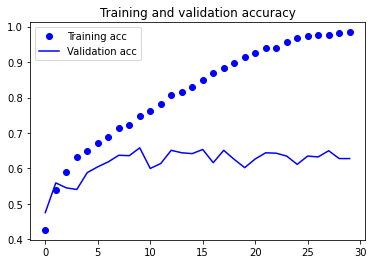

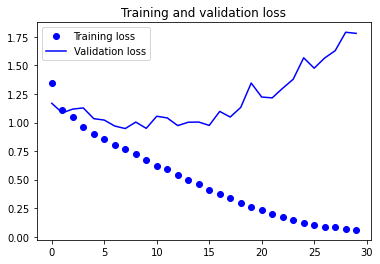

In [ ]:
# Write your code here

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [ ]:
# Write your code here
import math
TEST_STEPS=math.ceil(866/20)
preds_prob= model.predict(
    test_generator,
    steps=TEST_STEPS)

In [ ]:
true_labels=test_generator.classes
preds=list(map(np.argmax,preds_prob))

Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
# Write your code here
from sklearn import metrics
print(metrics.accuracy_score(true_labels,preds))
print(metrics.classification_report(true_labels,preds))

0.6674364896073903
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       175
           1       0.69      0.74      0.71       216
           2       0.59      0.49      0.54       148
           3       0.67      0.75      0.71       135
           4       0.63      0.67      0.65       192

    accuracy                           0.67       866
   macro avg       0.66      0.66      0.66       866
weighted avg       0.67      0.67      0.67       866



Print the confusion matrix

In [ ]:
# Write your code here
print(metrics.confusion_matrix(true_labels,preds))

[[116  29   8  14   8]
 [ 19 159   7  20  11]
 [  9  13  73   5  48]
 [  5  15   6 101   8]
 [  9  13  30  11 129]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
# Write your code here
from keras.models import load_model
model=load_model('flowers_model_1.h5')
test_loss_1, test_acc_1= model.evaluate(test_generator)

44/44 [==============================] - 4s 88ms/step - loss: 1.4706 - acc: 0.6674


In [ ]:
print(test_loss_1)
print(test_acc_1)

1.470624327659607
0.6674364805221558


Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [ ]:
# Write your code here


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 2593 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [ ]:
# Write your code here
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Epoch 1/30
129/129 [==============================] - 131s 1s/step - loss: 1.4128 - acc: 0.3634 - val_loss: 1.2477 - val_acc: 0.4337
Epoch 2/30
129/129 [==============================] - 130s 1s/step - loss: 1.2262 - acc: 0.4730 - val_loss: 1.1644 - val_acc: 0.4942
Epoch 3/30
129/129 [==============================] - 131s 1s/step - loss: 1.1670 - acc: 0.5021 - val_loss: 1.0924 - val_acc: 0.5523
Epoch 4/30
129/129 [==============================] - 136s 1s/step - loss: 1.1073 - acc: 0.5507 - val_loss: 1.1902 - val_acc: 0.5302
Epoch 5/30
129/129 [==============================] - 133s 1s/step - loss: 1.0655 - acc: 0.5725 - val_loss: 1.0169 - val_acc: 0.6047
Epoch 6/30
129/129 [==============================] - 132s 1s/step - loss: 1.0243 - acc: 0.6001 - val_loss: 1.0354 - val_acc: 0.5872
Epoch 7/30
129/129 [==============================] - 132s 1s/step - loss: 0.9916 - acc: 0.6075 - val_loss: 0.9546 - val_acc: 0.6233
Epoch 8/30
129/129 [==============================] - 132s 1s/step - 

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model.save('flowers_model_2.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

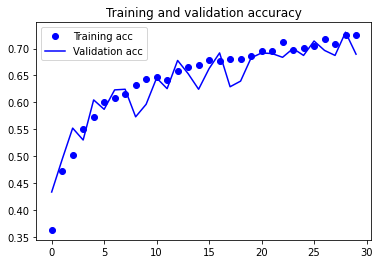

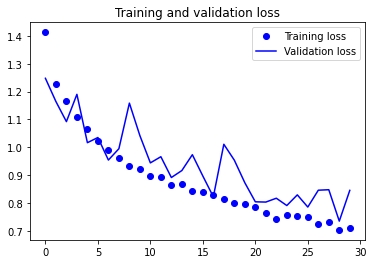

In [ ]:
# Write your code here
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [ ]:
# Write your code here
TEST_STEPS=math.ceil(866/20)
preds_prob= model.predict(
    test_generator,
    steps=TEST_STEPS)

true_labels=test_generator.classes
preds=list(map(np.argmax,preds_prob))

44/44 [==============================] - 12s 265ms/step - loss: 0.7888 - acc: 0.7044


In [ ]:
model=load_model('flowers_model_2.h5')

test_loss_2, test_acc_2= model.evaluate(test_generator)

44/44 [==============================] - 4s 86ms/step - loss: 0.7888 - acc: 0.7044


## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
from keras.applications import VGG16, InceptionV3

In [ ]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [ ]:
# Write your code
datagen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE=20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count,5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

The features and labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2593)
validation_features, validation_labels = extract_features(validation_dir, 864)
test_features, test_labels = extract_features(test_dir, 866)



Found 866 images belonging to 5 classes.


In [ ]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (866, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [ ]:
# Write your code
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['acc'])

Epoch 1/30
130/130 [==============================] - 6s 45ms/step - loss: 6.7944 - acc: 0.6186 - val_loss: 1.7323 - val_acc: 0.7546
Epoch 2/30
130/130 [==============================] - 5s 42ms/step - loss: 1.8762 - acc: 0.7655 - val_loss: 1.9142 - val_acc: 0.7396
Epoch 3/30
130/130 [==============================] - 6s 42ms/step - loss: 1.2449 - acc: 0.8052 - val_loss: 1.3524 - val_acc: 0.7616
Epoch 4/30
130/130 [==============================] - 6s 42ms/step - loss: 0.6547 - acc: 0.8585 - val_loss: 1.0256 - val_acc: 0.7986
Epoch 5/30
130/130 [==============================] - 6s 42ms/step - loss: 0.4996 - acc: 0.9005 - val_loss: 1.4410 - val_acc: 0.7789
Epoch 6/30
130/130 [==============================] - 5s 42ms/step - loss: 0.4215 - acc: 0.9125 - val_loss: 1.5995 - val_acc: 0.7882
Epoch 7/30
130/130 [==============================] - 6s 43ms/step - loss: 0.2155 - acc: 0.9510 - val_loss: 3.6146 - val_acc: 0.6725
Epoch 8/30
130/130 [==============================] - 6s 42ms/step - 

Fit your network

In [ ]:
# Write your code
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

In [ ]:
model.save('flowers_model_3.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

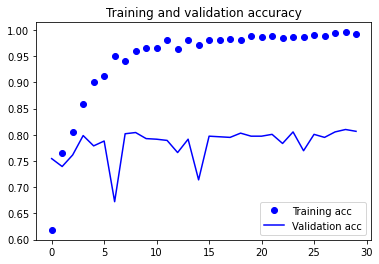

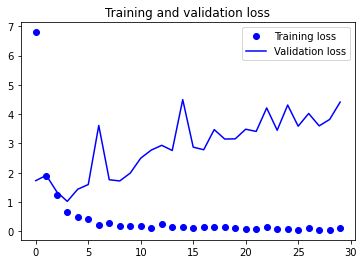

In [ ]:
# Write your code here
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

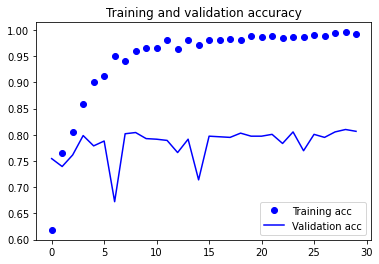

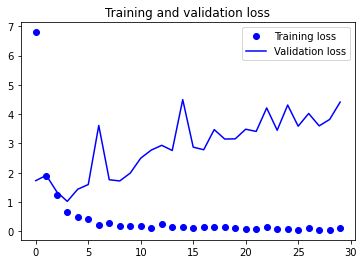

In [ ]:
# Write your code here
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model

model=load_model('flowers_model_3.h5')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 4,720,133
Trainable params: 4,720,133
Non-trainable params: 0
_________________________________________________________________


Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
# Write your code here
from sklearn import metrics
preds_prob= model.predict(test_features)
preds=list(map(np.argmax,preds_prob))
true_labels=list(map(np.argmax, test_labels))
print(metrics.accuracy_score(true_labels, preds))
print(metrics.classification_report(true_labels, preds))

0.8210161662817552
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       175
           1       0.87      0.87      0.87       216
           2       0.78      0.66      0.71       148
           3       0.80      0.85      0.83       135
           4       0.80      0.80      0.80       192

    accuracy                           0.82       866
   macro avg       0.82      0.82      0.81       866
weighted avg       0.82      0.82      0.82       866



Print the confusion matrix

In [ ]:
# Write your code here
print(metrics.confusion_matrix(true_labels, preds))

[[158   8   2   3   4]
 [ 11 188   2   8   7]
 [ 11   6  97   9  25]
 [  4   9   4 115   3]
 [  8   4  19   8 153]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
# Write your code here
test_loss_3, test_acc_3= model.evaluate(test_features,test_labels)

28/28 [==============================] - 0s 4ms/step - loss: 3.3313 - acc: 0.8210


## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
# Write you code
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

conv_base.trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['acc'])


Create the generators

In [ ]:
# Write your code



Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit the model

In [ ]:
# Write your code
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Epoch 1/30
129/129 [==============================] - 34s 267ms/step - loss: 7.6427 - acc: 0.5670 - val_loss: 1.4922 - val_acc: 0.6523
Epoch 2/30
129/129 [==============================] - 33s 255ms/step - loss: 1.5140 - acc: 0.6840 - val_loss: 1.0535 - val_acc: 0.7221
Epoch 3/30
129/129 [==============================] - 32s 251ms/step - loss: 0.9078 - acc: 0.7443 - val_loss: 0.7912 - val_acc: 0.7465
Epoch 4/30
129/129 [==============================] - 32s 246ms/step - loss: 0.7265 - acc: 0.7528 - val_loss: 0.6329 - val_acc: 0.8035
Epoch 5/30
129/129 [==============================] - 33s 256ms/step - loss: 0.6781 - acc: 0.7761 - val_loss: 0.7622 - val_acc: 0.7523
Epoch 6/30
129/129 [==============================] - 32s 249ms/step - loss: 0.5802 - acc: 0.8002 - val_loss: 0.6595 - val_acc: 0.7884
Epoch 7/30
129/129 [==============================] - 32s 245ms/step - loss: 0.5844 - acc: 0.8014 - val_loss: 0.5851 - val_acc: 0.7919
Epoch 8/30
129/129 [==============================] - 3

In [ ]:
model.save('flowers_model_4.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

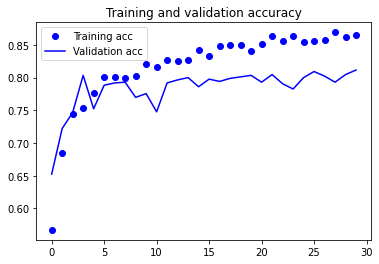

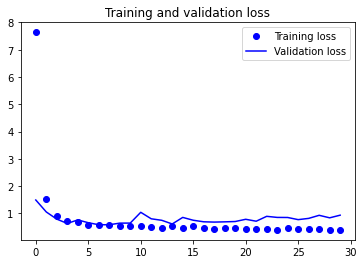

In [ ]:
# write your code
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [ ]:
# write your code
import math
TEST_STEPS=math.ceil(866/20)
preds_prob= model.predict(
    test_generator,
    steps=TEST_STEPS)

true_labels=test_generator.classes
preds=list(map(np.argmax,preds_prob))

Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
# write your code
from sklearn import metrics
print(metrics.accuracy_score(true_labels, preds))
print(metrics.classification_report(true_labels, preds))

0.8314087759815243
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       175
           1       0.83      0.91      0.87       216
           2       0.78      0.71      0.74       148
           3       0.78      0.85      0.82       135
           4       0.81      0.80      0.81       192

    accuracy                           0.83       866
   macro avg       0.83      0.83      0.83       866
weighted avg       0.83      0.83      0.83       866



Print the confusion matrix

In [ ]:
# write your code
print(metrics.confusion_matrix(true_labels, preds))

[[149  10   3   9   4]
 [  8 197   3   6   2]
 [  2   5 105   9  27]
 [  0  13   5 115   2]
 [  1  11  18   8 154]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
# Write your code
test_loss_4, test_acc_4= model.evaluate(test_generator)

44/44 [==============================] - 5s 115ms/step - loss: 0.6486 - acc: 0.8314


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [ ]:
(test_loss_1, test_acc_2), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((1.4706242084503174, 0.7043879628181458),
 (0.7887993454933167, 0.7043879628181458),
 (3.3313372135162354, 0.8210161924362183),
 (0.648628294467926, 0.8314087986946106))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.

You will submit this report through Canvas.

# Visualizing heatmaps of class activation

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/Colab Notebooks/flowers/daisy/100080576_f52e8ee070_n.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n11939491', 'daisy', 0.99336916), ('n02190166', 'fly', 0.0014243006), ('n02206856', 'bee', 0.0008635278)]


In [ ]:
np.argmax(preds[0])

985

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
african_elephant_output = model.output[:, 985]
last_conv_layer = model.get_layer('block5_conv3')
feature_extractor = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])
with tf.GradientTape() as tape:
    conv_layer_output_value, predictions = feature_extractor(x)
    loss = predictions[:, 985]
grads = tape.gradient(loss, conv_layer_output_value)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
conv_layer_output_value = tf.multiply(pooled_grads, conv_layer_output_value[0])
heatmap = np.mean(conv_layer_output_value, axis=-1)

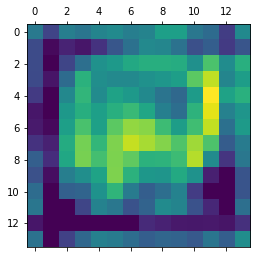

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

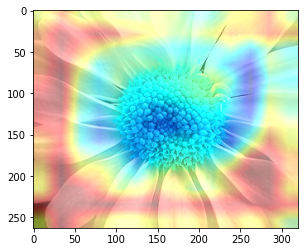

In [ ]:
import cv2
img = cv2.imread(img_path)/255.
plt.imshow(img)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
plt.imshow(heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4/255. + img 
plt.imshow(superimposed_img)
os.chdir('/content/drive/MyDrive/Colab Notebooks')
cv2.imwrite('daisy_heatmap.jpg', 255*superimposed_img)